In [1]:
# Imports 
from pathlib import Path
import torch
import matplotlib.pyplot as plt

from torch.utils.data import random_split, DataLoader

In [2]:
# Import own helpers
from vesuvius.data.vesuvius_train import VesuviusTrainDataset
from vesuvius.data.subset_with_transform import SubsetWithTransform
from vesuvius.transforms.volume import Compose, NormalizeVolume, RandomCrop3D, CenterCrop3D

from vesuvius.visualization.patch_grid import plot_transformed_patch_grid

In [3]:
# Root folder path
ROOT = Path("~/vesuvius-scroll-detection/data/raw/vesuvius").expanduser()

print("ROOT:", ROOT)

ROOT: /Users/chamu/vesuvius-scroll-detection/data/raw/vesuvius


In [4]:
# Device selection
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print("Device:", device)

Device: mps


In [5]:
# Load base dataset (no transforms yet)
ds = VesuviusTrainDataset(ROOT)
print("Dataset size:", len(ds))

img, mask, sid = ds[0]
print("Example sid:", sid)
print("Full volume img:", tuple(img.shape))
print("Full volume mask:", tuple(mask.shape))

Dataset size: 806
Example sid: 2290837
Full volume img: (1, 320, 320, 320)
Full volume mask: (1, 320, 320, 320)


In [6]:
# Split allocation for training
val_fraction = 0.15
seed = 0

n_total = len(ds)
n_val = max(1, int(val_fraction * n_total))
n_train = n_total - n_val

g = torch.Generator().manual_seed(seed)
train_subset, val_subset = random_split(ds, [n_train, n_val], generator=g)

In [7]:
print("Train subset:", len(train_subset))
print("Val subset:", len(val_subset))

Train subset: 686
Val subset: 120


In [8]:
# Define patch transforms
PATCH = (32, 96, 96)  # (D, H, W) 

train_tf = Compose([
    RandomCrop3D(PATCH),
    NormalizeVolume(eps=1e-6),
])

val_tf = Compose([
    CenterCrop3D(PATCH),
    NormalizeVolume(eps=1e-6),
])

In [9]:
print("PATCH:", PATCH)
print("train_tf:", train_tf.transforms)
print("val_tf:", val_tf.transforms)

PATCH: (32, 96, 96)
train_tf: [RandomCrop3D(crop_size=(32, 96, 96)), NormalizeVolume(mean=None, std=None, eps=1e-06)]
val_tf: [CenterCrop3D(crop_size=(32, 96, 96)), NormalizeVolume(mean=None, std=None, eps=1e-06)]


In [10]:
# Wrap splits with transforms
train_ds = SubsetWithTransform(train_subset, transform=train_tf)
val_ds   = SubsetWithTransform(val_subset, transform=val_tf)

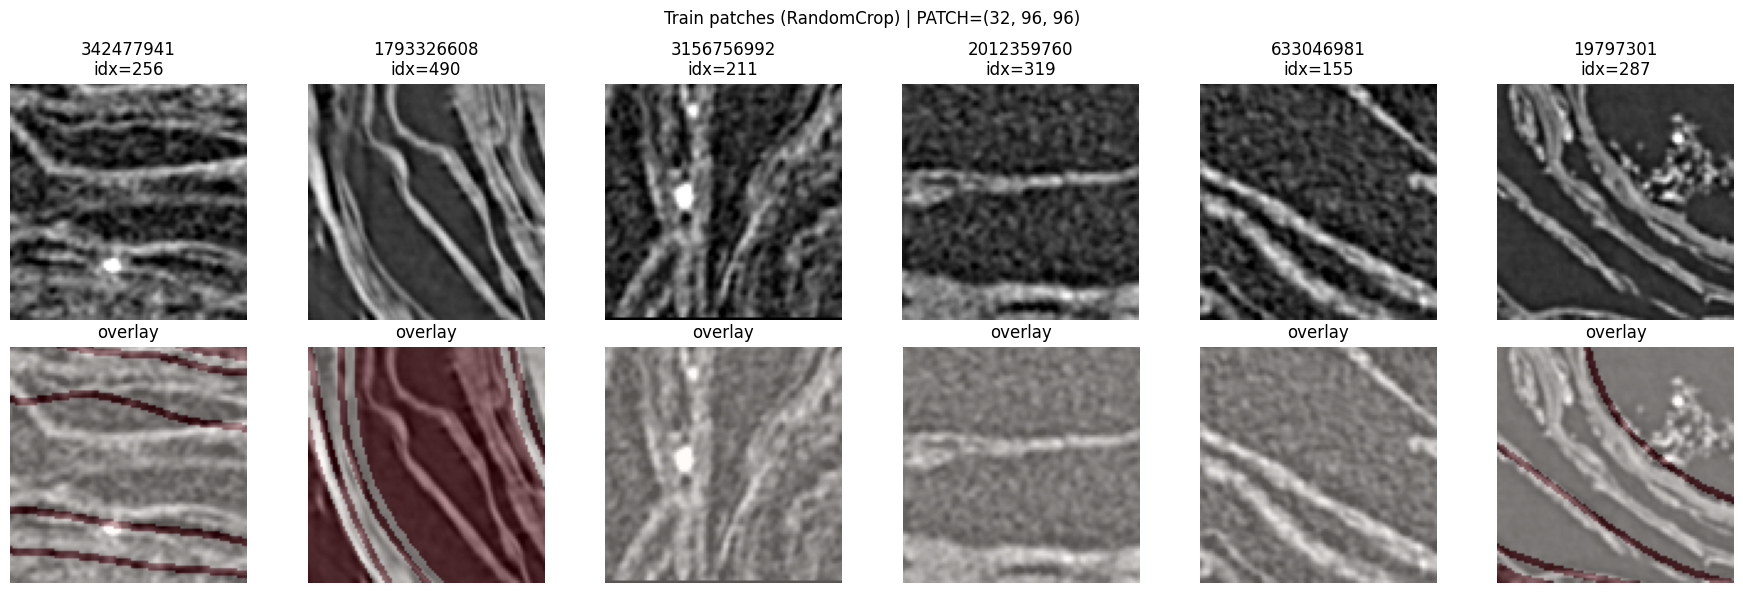

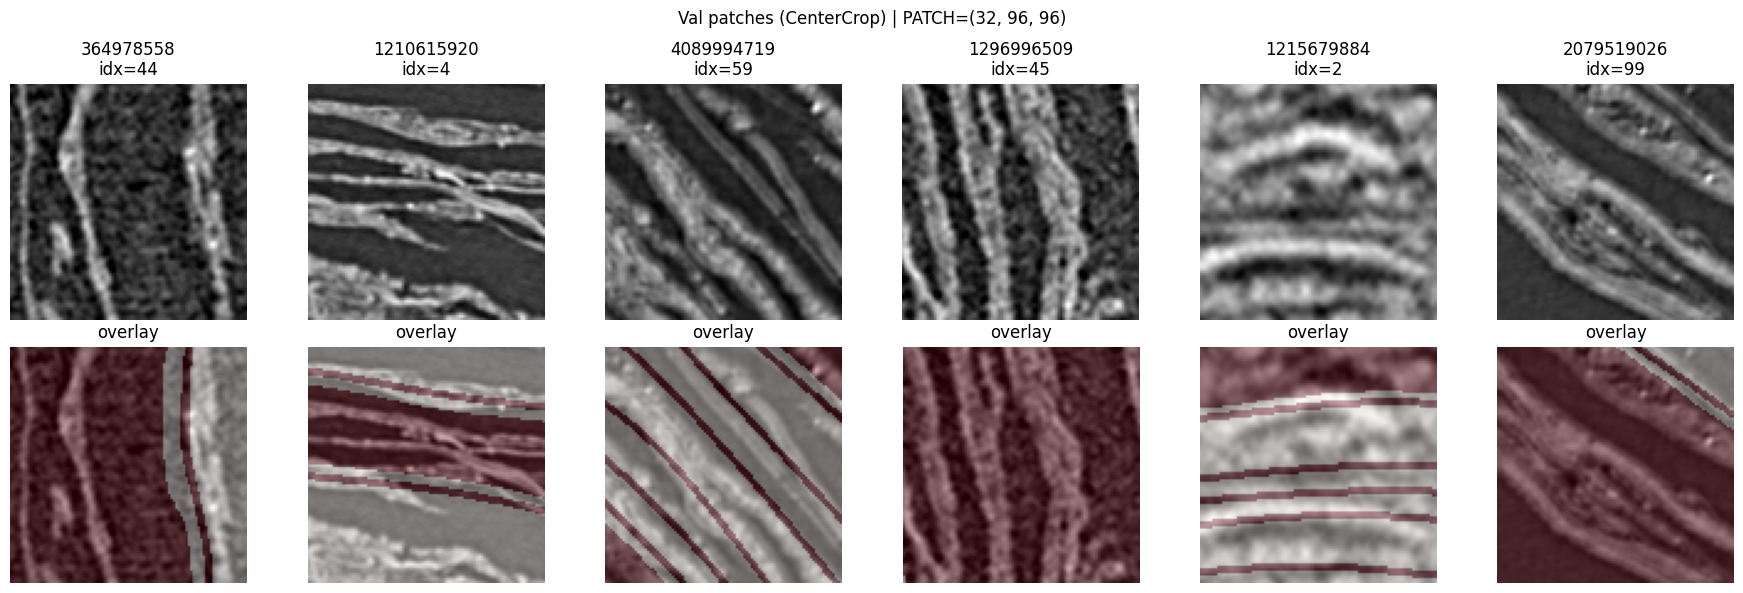

In [11]:
plot_transformed_patch_grid(
    train_ds,
    n=6,
    seed=0,
    title=f"Train patches (RandomCrop) | PATCH={PATCH}",
)

plot_transformed_patch_grid(
    val_ds,
    n=6,
    seed=0,
    title=f"Val patches (CenterCrop) | PATCH={PATCH}",
)

In [12]:
# Make loaders
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

imgs, masks, sids = next(iter(train_loader))
print("Batch imgs:", tuple(imgs.shape))
print("Batch masks:", tuple(masks.shape))
print("sids:", sids)

Batch imgs: (1, 1, 32, 96, 96)
Batch masks: (1, 1, 32, 96, 96)
sids: ('110997297',)


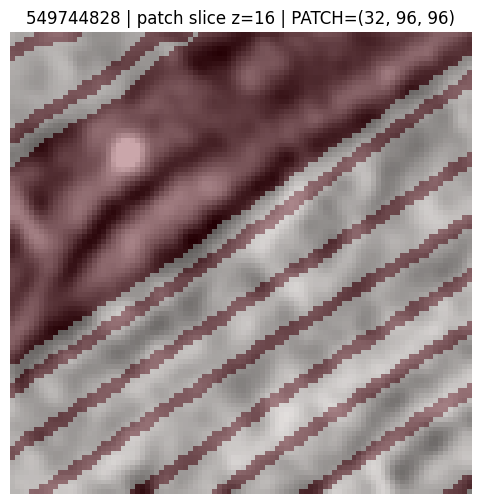

In [13]:
# Visual sanity check
imgs, masks, sids = next(iter(train_loader))
img = imgs[0]     # (1, D, H, W)
mask = masks[0]   # (1, D, H, W)
sid = sids[0]

z = img.shape[1] // 2

plt.figure(figsize=(6,6))
plt.imshow(img[0, z], cmap="gray")
plt.imshow(mask[0, z] > 0, alpha=0.35, cmap="Reds")
plt.title(f"{sid} | patch slice z={z} | PATCH={PATCH}")
plt.axis("off")
plt.show()

In [ ]:
# Check if normalisation worked, i.e. transform order correct and no bugs
print("img mean:", img.mean().item())
print("img std :", img.std().item())

# Check that masks are not binary, i.e. 0: background, 1: papyrus surface, 2: ignore / uncertain
print("mask unique (sample):", torch.unique(mask)[:10]) 

img mean: -3.154079024625389e-07
img std : 0.9999999403953552
mask unique (sample): tensor([0., 1., 2.])
